# Audio and spectrograms
This tutorial demonstrates how to use OpenSoundscape to open and modify audio files and spectrograms.

Audio files can be loaded into OpenSoundscape and modified using its `Audio` class. The class gives access to modifications such as trimming short clips from longer recordings, splitting a long clip into multiple segments, bandpassing recordings, and extending the length of recordings by looping them. Spectrograms can be created from `Audio` objects using the `Spectrogram` class. This class also allows useful features like measuring the amplitude signal of a recording, trimming a spectrogram in time and frequency, and converting the spectrogram to a saveable image.

To download the tutorial as a Jupyter Notebook, click the "Edit on GitHub" button at the top right of the tutorial. Using it requires that you install OpenSoundscape and follow the instructions for using it in Jupyter.

This tutorial uses an example audio file downloadable with the OpenSoundscape package. To use your own file for the following examples, replace the path in the line below with the absolute path to the file:

In [1]:
audio_filename = "../../tests/audio/1min.wav"

NOTE: If this cell raises an error for you, make sure to replace  `"../../tests/audio/1min.wav"` with a path to an audio file on your computer, in quotes. 

## Quick start

Import the `Audio` and `Spectrogram` classes from OpenSoundscape. (For more information about Python imports, review [this](https://medium.com/code-85/a-beginners-guide-to-importing-in-python-bb3adbbacc2b) article.)

In [2]:
# import Audio and Spectrogram classes from OpenSoundscape
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

These classes provide a variety of tools to load and manipulate audio and spectrograms. The code below demonstrates a basic pipeline:
- load an audio file
- generate a spectrogram with default parameters
- create a 224px x 224px-sized image of the spectrogram
- save the image to a file

In [3]:
from pathlib import Path

# Settings
image_shape = (224, 224)
image_path = Path('./saved_spectrogram.png')

# Load audio file as Audio object
audio = Audio.from_file(audio_filename)

# Create Spectrogram object from Audio object
spectrogram = Spectrogram.from_audio(audio)

# Convert Spectrogram object to PIL Image
image = spectrogram.to_image(shape=image_shape)

# Save image to file
image.save(image_path)

The above function calls could even be condensed to a single line:

In [4]:
Spectrogram.from_audio(Audio.from_file(audio_filename)).to_image(shape=image_shape).save(image_path)

Clean up by deleting the spectrogram saved above.

In [5]:
image_path.unlink()

## Audio loading

The `Audio` class in OpenSoundscape allows loading and manipulation of audio files. 

### Load .wavs
Load the example audio from file:

In [6]:
audio_object = Audio.from_file(audio_filename)

### Load .mp3s

OpenSoundscape uses a package called `librosa` to help load audio files. Librosa automatically supports `.wav` files, but loading `.mp3` files requires that you also install `ffmpeg` or an alternative. See [Librosa's installation tips](https://github.com/librosa/librosa#Hints-for-the-installation) for more information.


### Audio properties

The properties of an `Audio` object include its samples (the actual audio data) and the sample rate (the number of audio samples taken per second, required to understand the samples). After an audio file has been loaded, these properties can be accessed using the `samples` and `sample_rate` attributes, respectively.

In [7]:
print(f"How many samples does this audio object have? {len(audio_object.samples)}")
print(f"What is the sampling rate? {audio_object.sample_rate}")

How many samples does this audio object have? 1920000
What is the sampling rate? 32000


### Resample audio during load

By default, an audio object is loaded with the same sample rate as the source recording. 

The `sample_rate` parameter of `Audio.from_file` allows you to re-sample the file during the creation of the object. This is useful when working with multiple files to ensure that all files have a consistent sampling rate.

Let's load the same audio file as above, but specify a sampling rate of 22050 Hz.

In [8]:
audio_object_resample = Audio.from_file(audio_filename, sample_rate=22050)
audio_object_resample.sample_rate

22050

For other options when loading audio objects, see the [Audio.from_file() documentation](api/audio.html#opensoundscape.audio.Audio.from_file).

## Audio methods

The `Audio` class gives access to a variety of tools to change audio files, load them with special properties, or get information about them. Various examples are shown below.

For a description of the entire `Audio` object API, see the [API documentation](api/audio.html).

### Out-of-place operations

Functions that modify `Audio` (and `Spectrogram`) objects are "out of place", meaning that they return a new, modified instance of `Audio` instead of modifying the original instance. This means that running a line
```
audio_object.resample(22050) # WRONG!
```
will **not** change the sample rate of `audio_object`! If your goal was to overwrite `audio_object` with the new, resampled audio, you would instead write
```
audio_object = audio_object.resample(22050)
```


### Save audio to file
Opensoundscape currently supports saving Audio objects to `.wav` formats **only**. 

In [9]:
audio_object.save('./my_audio.wav')

clean up: delete saved file

In [10]:
from pathlib import Path
Path('./my_audio.wav').unlink()

### Get duration
The `.duration()` method returns the length of the audio in seconds

In [11]:
length = audio_object.duration()
print(length)

60.0


### Trim
The `.trim()` method extracts audio from a specified time period in seconds (relative to the start of the audio object).

In [12]:
trimmed = audio_object.trim(0,5)
trimmed.duration()

5.0

### Split
The `.split()` method divides audio into even-lengthed clips, optionally with overlap between adjacent clips (default is no overlap). See the function's documentation for options on how to handle the last clip.

The function returns a list of dictionaries, with each dictionary containing an audio clip and information about the clip. 

In [13]:
#split into 5-second clips with no overlap between adjascent clips
clips_and_info = audio_object.split(clip_duration=5,clip_overlap=0,final_clip=None)

#check the duration of the Audio object in the first returned element
clips_and_info[0]['clip'].duration()

5.0

### Extend and loop
The `.extend()` method extends an audio file to a desired length by adding silence to the end.

The `.loop()` method extends an audio file to a desired length (or number of repetitions) by looping the audio. 


10.0


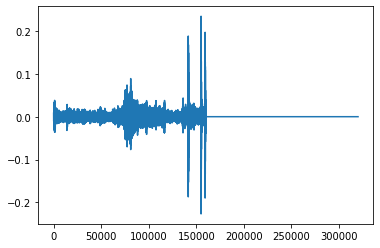

In [14]:
import matplotlib.pyplot as plt

# create an audio object twice as long, extending the end with silence (zero-values)
extended = trimmed.extend(trimmed.duration() * 2)
print(extended.duration())
plt.plot(extended.samples)

7.5


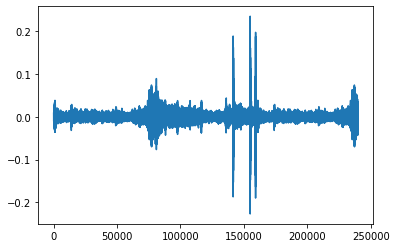

In [15]:
# create an audio object 1.5x as long, extending the end by looping
looped = trimmed.loop(trimmed.duration() * 1.5)
print(looped.duration())
plt.plot(looped.samples)

25.0


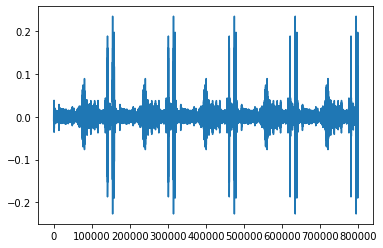

In [16]:
# create an audio object that loops the original object 3 times
looped = trimmed.loop(n=5)
print(looped.duration())
plt.plot(looped.samples)

### Resample
The `.resample()` method resamples the audio object to a new sampling rate (can be lower or higher than the original sampling rate)

In [17]:
resampled = audio_object.resample(sample_rate=48000)
resampled.sample_rate

48000

### Generate a frequency spectrum
The `.spectrum()` method provides an easy way to compute a Fast Fourier Transform on an audio object to see its frequency composition. 

Text(0.5, 0, 'Frequency (Hz)')

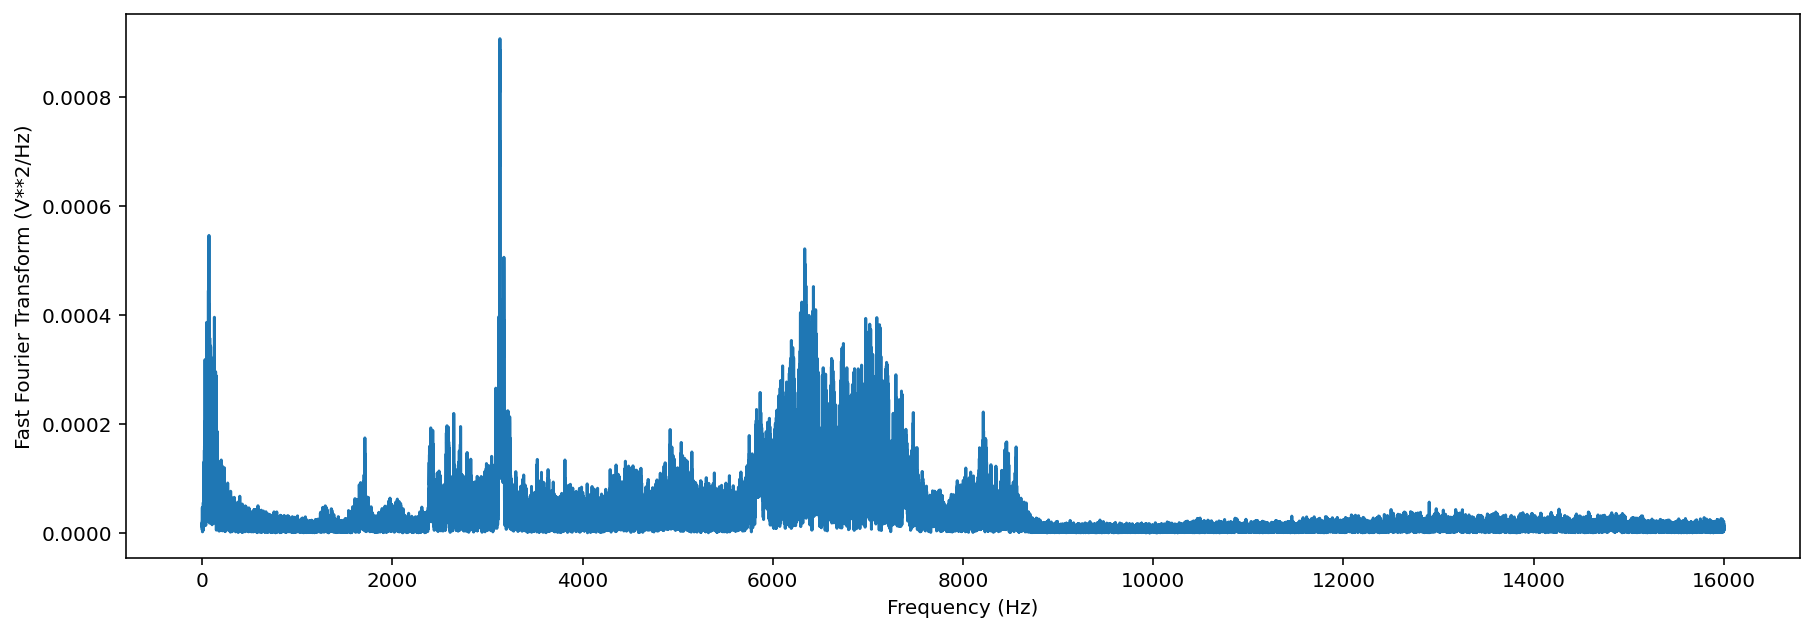

In [18]:
# calculate the fft
fft_spectrum, frequencies = trimmed.spectrum()

#plot settings
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

# plot
plt.plot(frequencies,fft_spectrum)
plt.ylabel('Fast Fourier Transform (V**2/Hz)')
plt.xlabel('Frequency (Hz)')

### Bandpass
Bandpass the audio file to limit its frequency range to 1000 Hz to 5000 Hz. The bandpass operation uses a Butterworth filter with a user-provided order.

Text(0.5, 0, 'Frequency (Hz)')

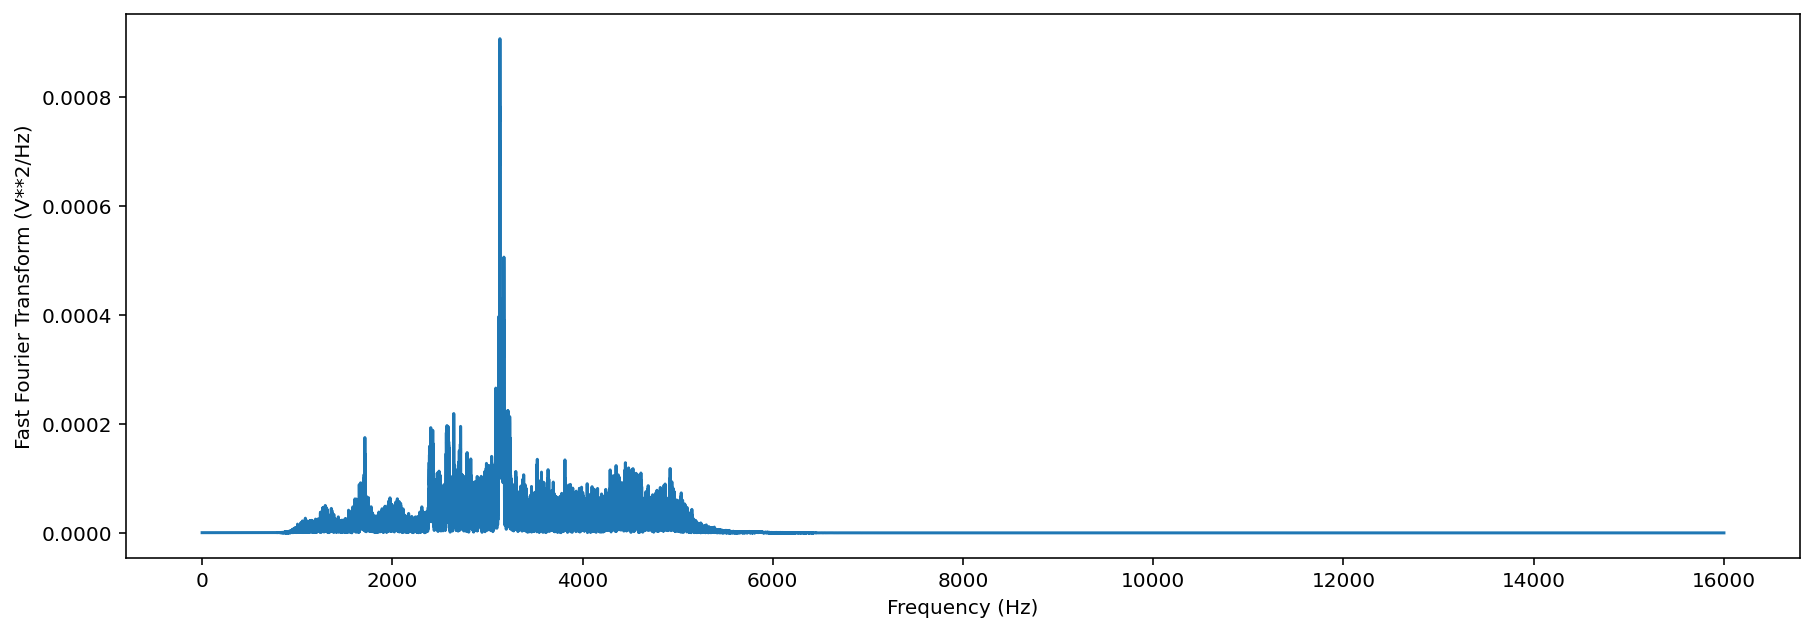

In [19]:
# apply a bandpass filter
bandpassed = trimmed.bandpass(low_f = 1000, high_f = 5000, order=9)

# calculate the bandpassed audio's spectrum
fft_spectrum, frequencies = bandpassed.spectrum()

# plot
plt.plot(frequencies,fft_spectrum)
plt.ylabel('Fast Fourier Transform (V**2/Hz)')
plt.xlabel('Frequency (Hz)')

## Spectrogram creation

### Load spectrogram
A `Spectrogram` object can be created from an audio object using the `from_audio()` method.

In [20]:
audio_object = Audio.from_file(audio_filename)
spectrogram_object = Spectrogram.from_audio(audio_object)

Spectrograms can also be loaded from saved images using the `from_file()` method.

### Spectrogram properties

To check the time and frequency axes of a spectrogram, you can look at its `times` and `frequencies` attributes. The `times` attribute is the list of the spectrogram windows' centers' times in seconds relative to the beginning of the audio. The `frequencies` attribute is the list of frequencies represented by each row of the spectrogram. These are not the actual values of the spectrogram — just the values of the axes.

In [21]:
spec = Spectrogram.from_audio(Audio.from_file(audio_filename))
print(f'the first few times: {spec.times[0:5]}')
print(f'the first few frequencies: {spec.frequencies[0:5]}')

the first few times: [0.008 0.016 0.024 0.032 0.04 ]
the first few frequencies: [  0.   62.5 125.  187.5 250. ]


### Plot spectrogram
A `Spectrogram` object can be visualized using its `plot()` method.

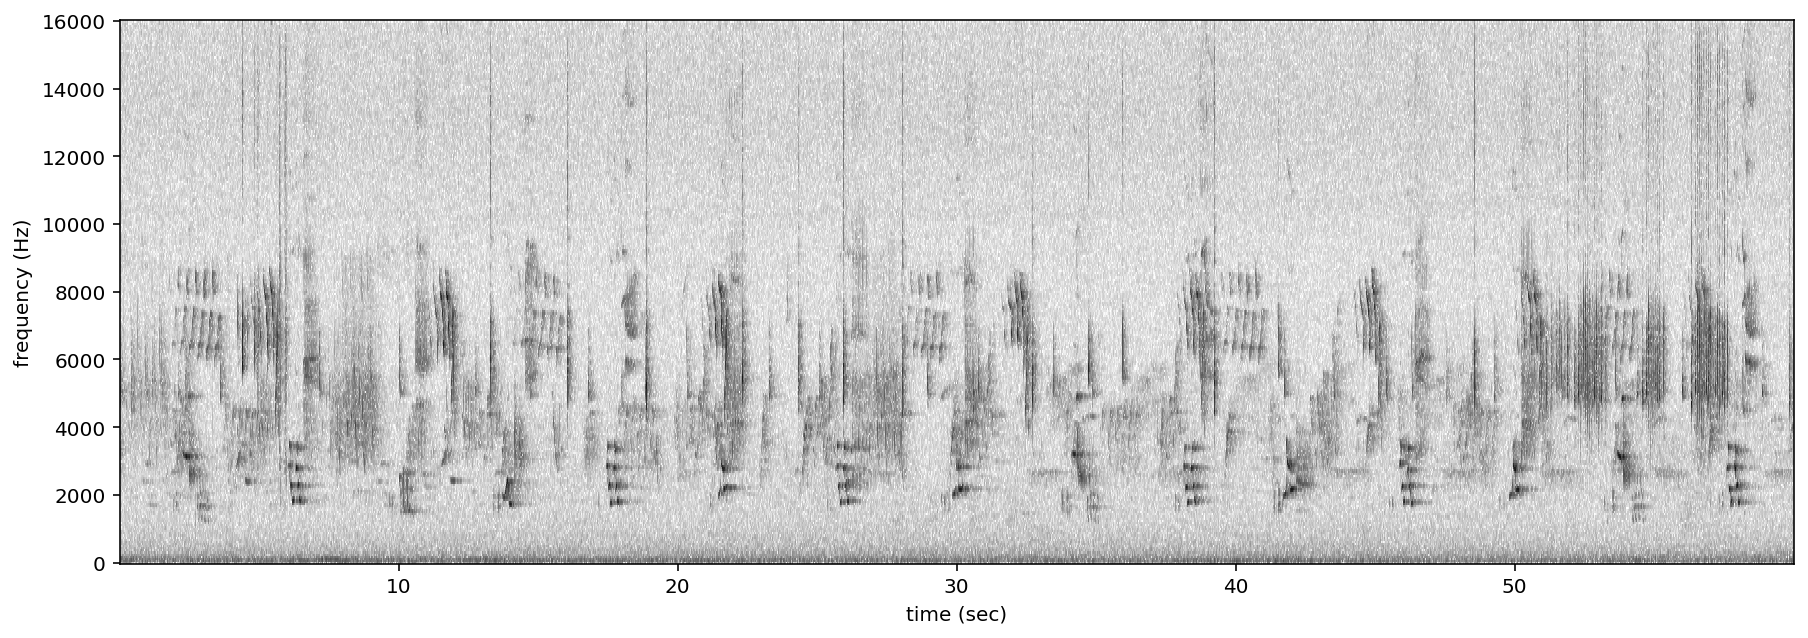

In [22]:
audio_object = Audio.from_file(audio_filename)
spectrogram_object = Spectrogram.from_audio(audio_object)
spectrogram_object.plot()

### Spectrogram parameters

Spectrograms are created using "windows." A window is a subset of consecutive samples of the original audio that is analyzed to create one pixel in the horizontal direction (one "column") on the resulting spectrogram. The appearance of a spectrogram depends on two parameters that control the size and spacing of these windows:

#### Samples per window, `window_samples`
This parameter is the length (in audio samples) of each spectrogram window. Choosing the value for `window_samples` represents a trade-off between frequency resolution and time resolution:

* Larger value for `window_samples` --> higher frequency resolution (more rows in a single spectrogram column)
* Smaller value for `window_samples` --> higher time resolution (more columns in the spectrogram per second)

#### Overlap of consecutive windows, `overlap_samples`
`overlap_samples`: this is the number of audio samples that will be re-used (overlap) between two consecutive Specrogram windows. It must be less than `window_samples` and greater than or equal to zero. Zero means no overlap between windows, while a value of `window_samples`/2 would give 50% overlap between consecutive windows. Using higher overlap percentages can sometimes yield better time resolution in a spectrogram, but will take more computational time to generate. 

#### Relationship

When there is zero overlap between windows, the number of columns per second is equal to the size in Hz of each spectrogram row. Consider the relationship between time resolution (columns in the spectrogram per second) and frequency resolution (rows in a given frequency range) in the following example:

* Let `sample_rate=48000`, `window_samples=480`, and `overlap_samples=0`
* Each window ("spectrogram column") represents `480/48000 = 1/100 = 0.01` seconds of audio
* There will be `1/(length of window in seconds) = 1/0.01` = 100 columns in the spectrogram per second.
* Each pixel will span 100 Hz in the frequency dimension, i.e., the lowest pixel spans 0-100 Hz, the next lowest 100-200 Hz, then 200-300 Hz, etc.

If `window_samples=4800`, then the spectrogram would have better time resolution (each window represents only 4800/48000 = 0.001s of audio) but worse frequency resolution (each row of the spectrogram would represent 1000 Hz in the frequency range).

As an example, let's create two spectrograms, one with hight time resolution and another with high frequency resolution.

In [23]:
# Load audio
audio = Audio.from_file(audio_filename, sample_rate=22000).trim(0,5)

**Create a spectrogram with high time resolution**

Using `window_samples=55` and `overlap_samples=0` gives 55/22000 = 0.0025 seconds of audio per window, or 1/0.0025 = 400 windows per second. Each spectrogram pixel spans 400 Hz.

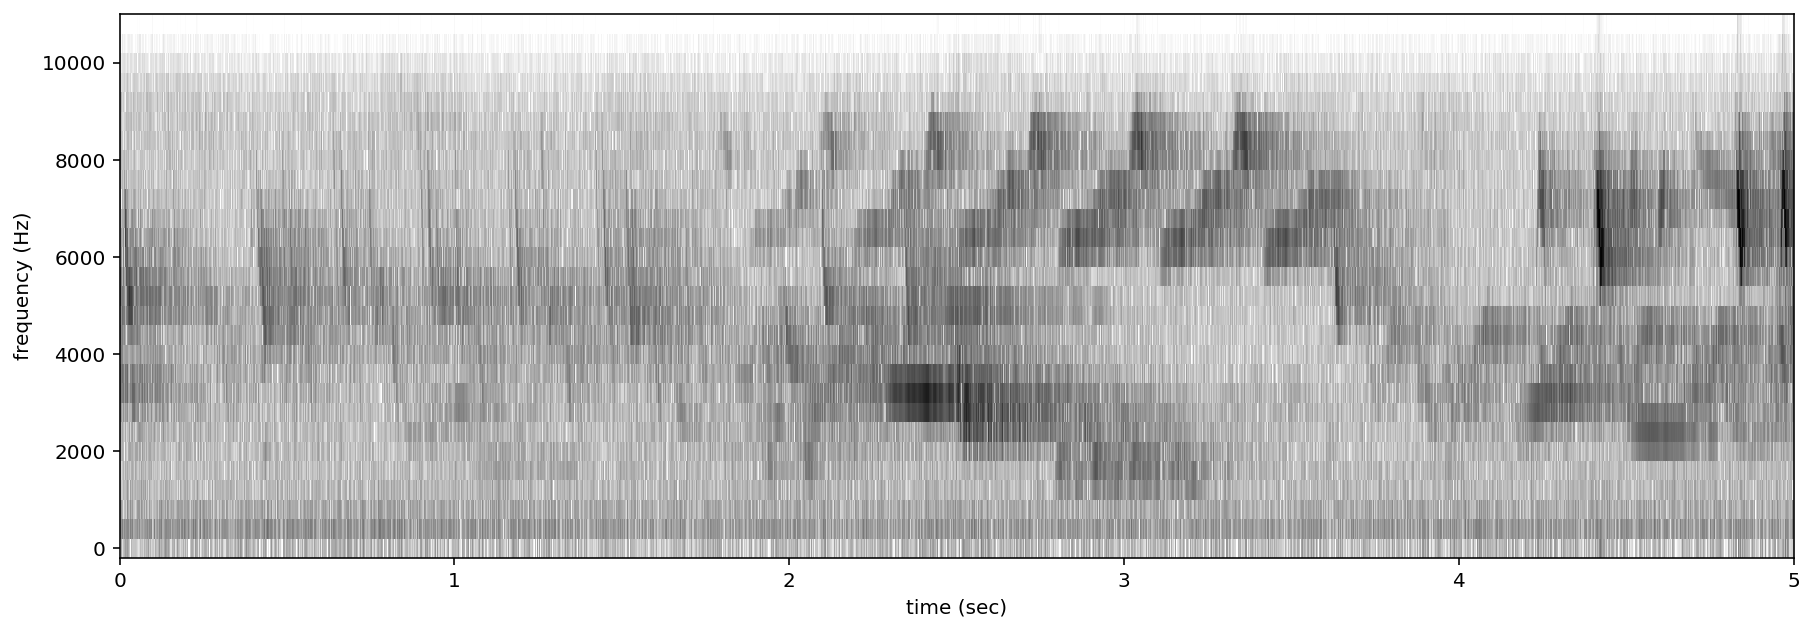

In [24]:
spec = Spectrogram.from_audio(audio, window_samples=55, overlap_samples=0)
spec.plot()

**Create a spectrogram with high time frequency resolution**

Using `window_samples=1100` and `overlap_samples=0` gives 1100/22000 = 0.05 seconds of audio per window, or 1/0.05 = 20 windows per second. Each spectrogram pixel spans 20 Hz.

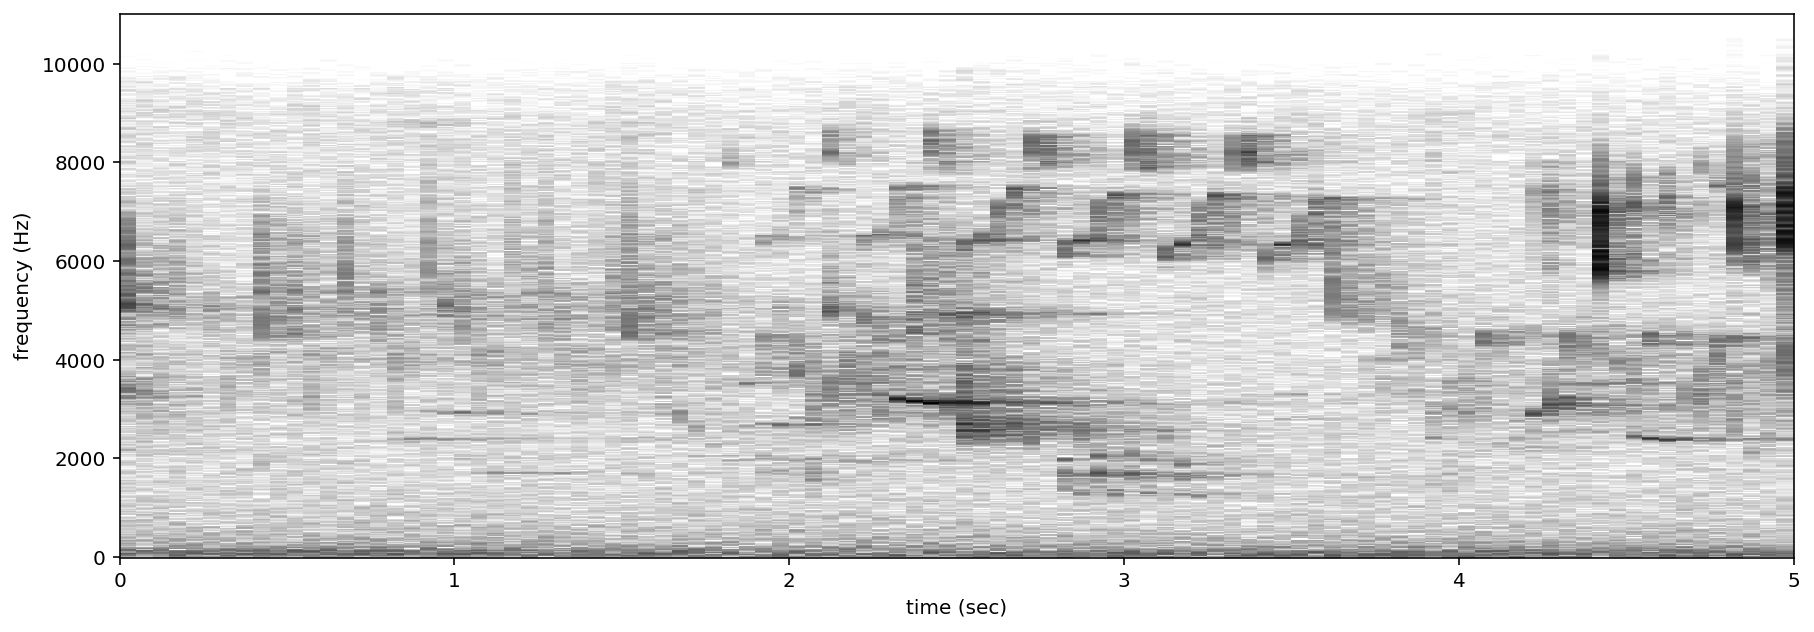

In [25]:
spec = Spectrogram.from_audio(audio, window_samples=1100, overlap_samples=0)
spec.plot()

For other options when loading spectrogram objects from audio objects, see the `from_audio()` documentation.

## Spectrogram methods

The tools and features of the spectrogram class are demonstrated here, including plotting; how spectrograms can be generated from modified audio; saving a spectrogram as an image; customizing a spectrogram; trimming and bandpassing a spectrogram; and calculating the amplitude signal from a spectrogram.

### Plot
A `Spectrogram` object can be plotted using its `plot()` method.

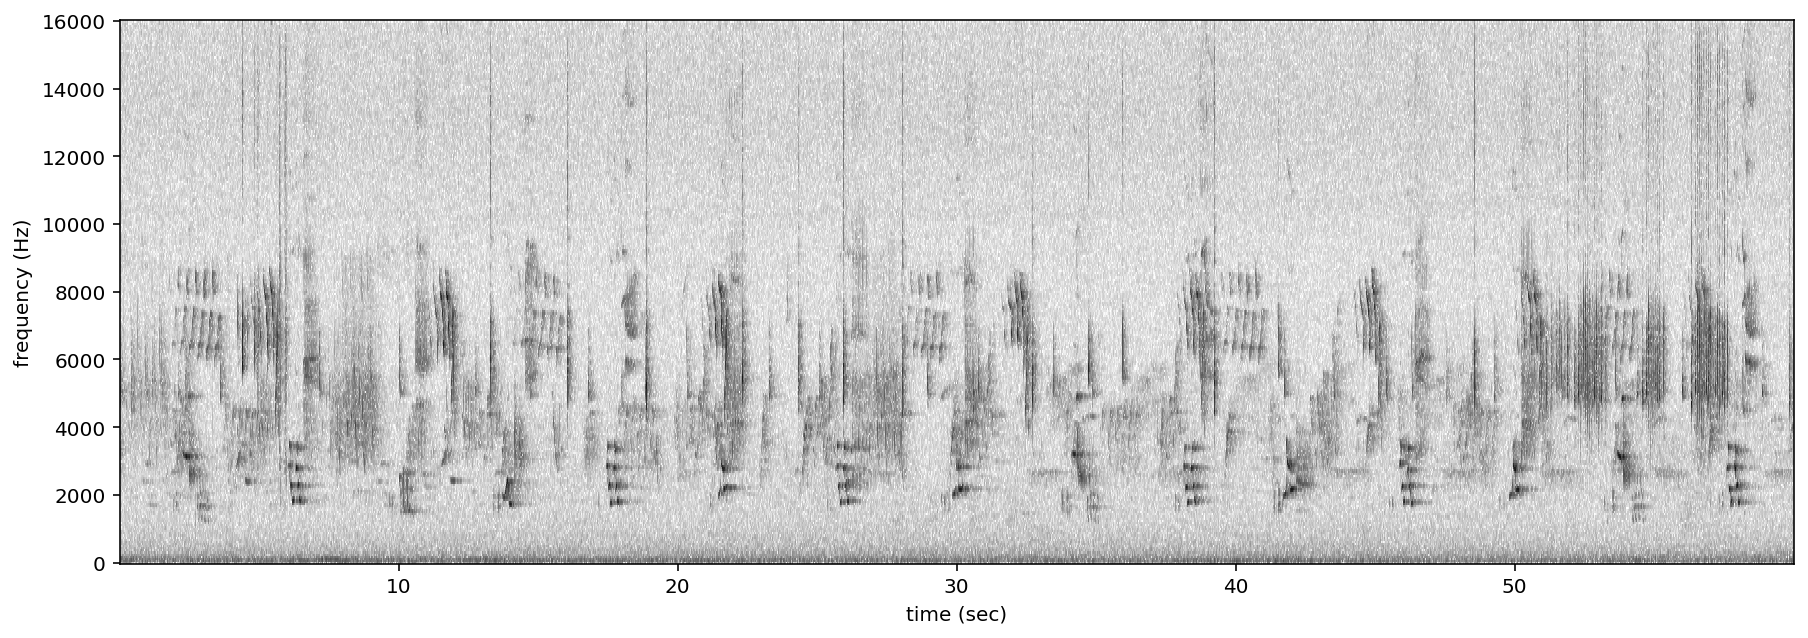

In [26]:
audio_object = Audio.from_file(audio_filename)
spectrogram_object = Spectrogram.from_audio(audio_object)
spectrogram_object.plot()

### Load modified audio

Sometimes, you may wish to trim or modify an audio object before creating a spectrogram. In this case, you should first modify the Audio object, then call `Spectrogram.from_audio()`. 

For example, the code below demonstrates creating a spectrogram from a 5 second long trim of the audio object. Compare this plot to the plot above.

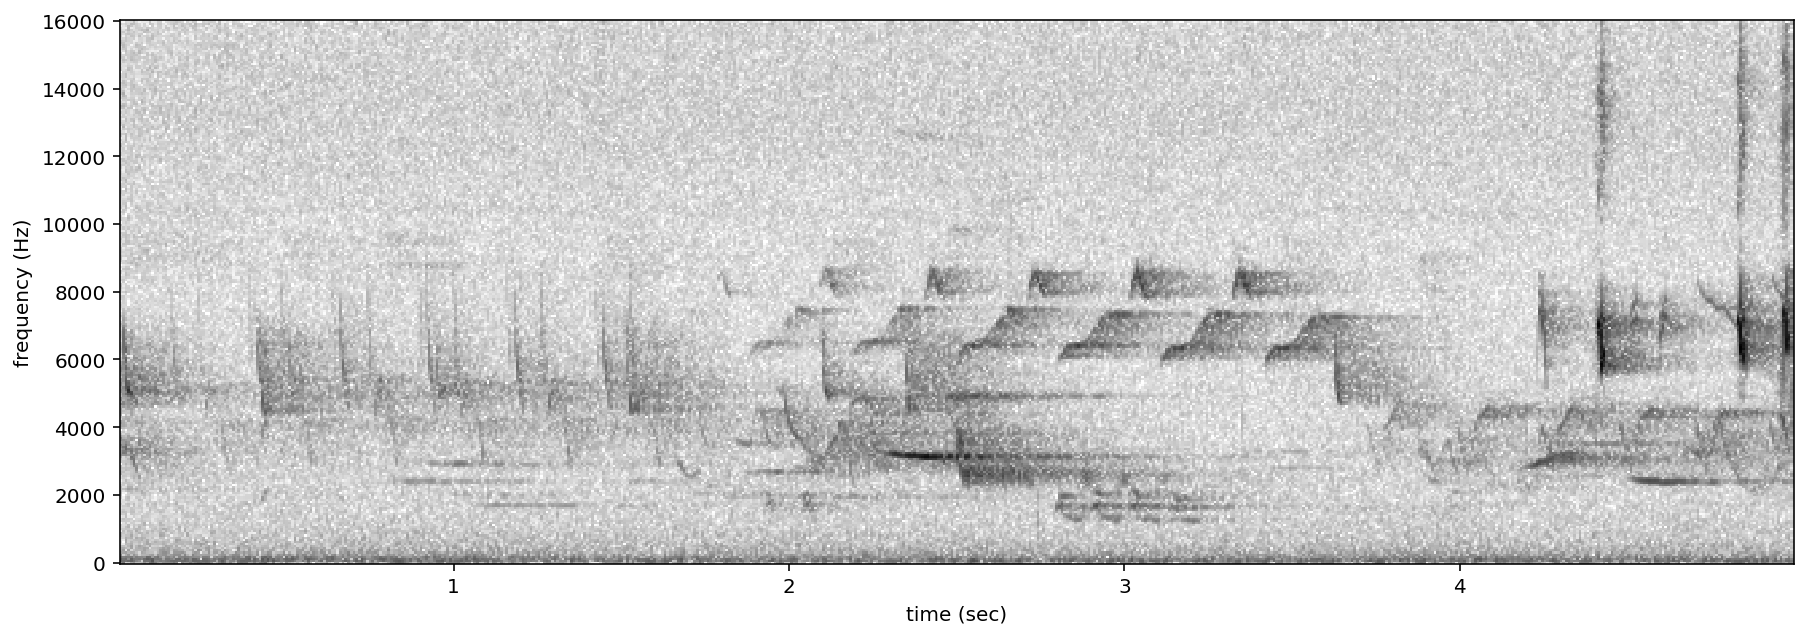

In [27]:
# Trim the original audio
trimmed = audio_object.trim(0, 5)

# Create a spectrogram from the trimmed audio
spec = Spectrogram.from_audio(trimmed)

# Plot the spectrogram
spec.plot()

### Save spectrogram to file

To save the created spectrogram, first convert it to an image. It will no longer be an OpenSoundscape `Spectrogram` object, but instead a Python Image Library (PIL) `Image` object.

In [28]:
print("Type of `spectrogram_audio` (before conversion):", type(spectrogram_object))
spectrogram_image = spectrogram_object.to_image()
print("Type of `spectrogram_image` (after conversion):", type(spectrogram_image))

Type of `spectrogram_audio` (before conversion): <class 'opensoundscape.spectrogram.Spectrogram'>
Type of `spectrogram_image` (after conversion): <class 'PIL.Image.Image'>


Save the PIL Image using its `save()` method, supplying the filename at which you want to save the image.

In [29]:
image_path = Path('./saved_spectrogram.png')
spectrogram_image.save(image_path)

To save the spectrogram at a desired size, specify the image shape when converting the `Spectrogram` to a PIL `Image`.

In [30]:
image_shape = (512,512)
large_image_path = Path('./saved_spectrogram_large.png')
spectrogram_image = spectrogram_object.to_image(shape=image_shape)
spectrogram_image.save(large_image_path)

Delete the files created above.

In [31]:
image_path.unlink()
large_image_path.unlink()

### Trim

Spectrograms can be trimmed in time using `trim()`. Trim the above spectrogram to zoom in on one vocalization.

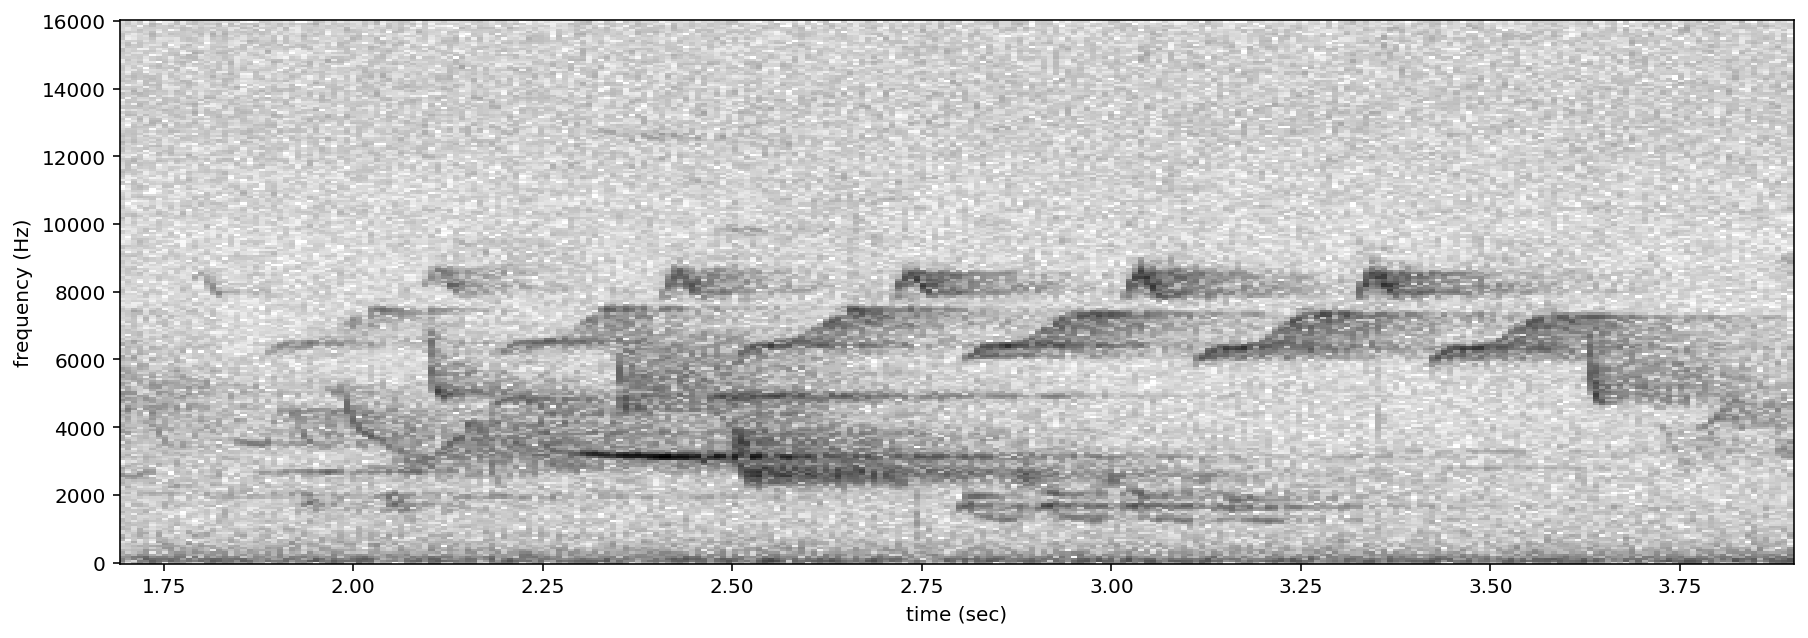

In [32]:
spec_trimmed = spec.trim(1.7, 3.9)
spec_trimmed.plot()

### Bandpass
Spectrograms can be trimmed in frequency using `bandpass()`. This simply subsets the Spectrogram array rather than performing an audio-domain filter.

For instance, the vocalization zoomed in on above is the song of a Black-and-white Warbler (*Mniotilta varia*), one of the highest-frequency bird songs in our area. Set its approximate frequency range.

In [33]:
baww_low_freq = 5500
baww_high_freq = 9500

Bandpass the above time-trimmed spectrogram in frequency as well to limit the spectrogram view to the vocalization of interest.

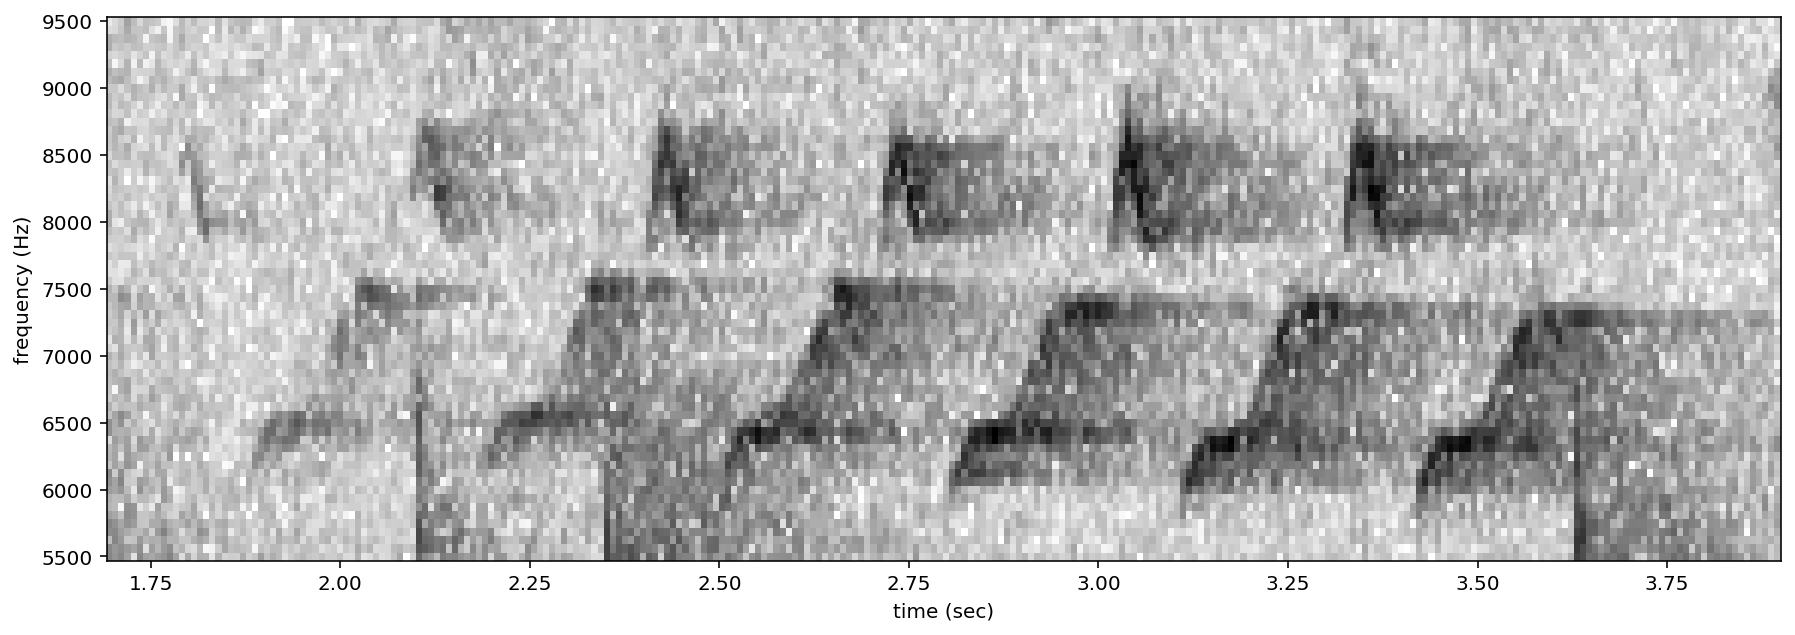

In [34]:
spec_bandpassed = spec_trimmed.bandpass(baww_low_freq, baww_high_freq)
spec_bandpassed.plot()

### Calculate amplitude signal

The `.amplitude()` method sums the columns of the spectrogram to create a one-dimensional amplitude versus time vector. 

Note: the amplitude of the Spectrogram (and FFT) has units of power (V**2) over frequency (Hz)

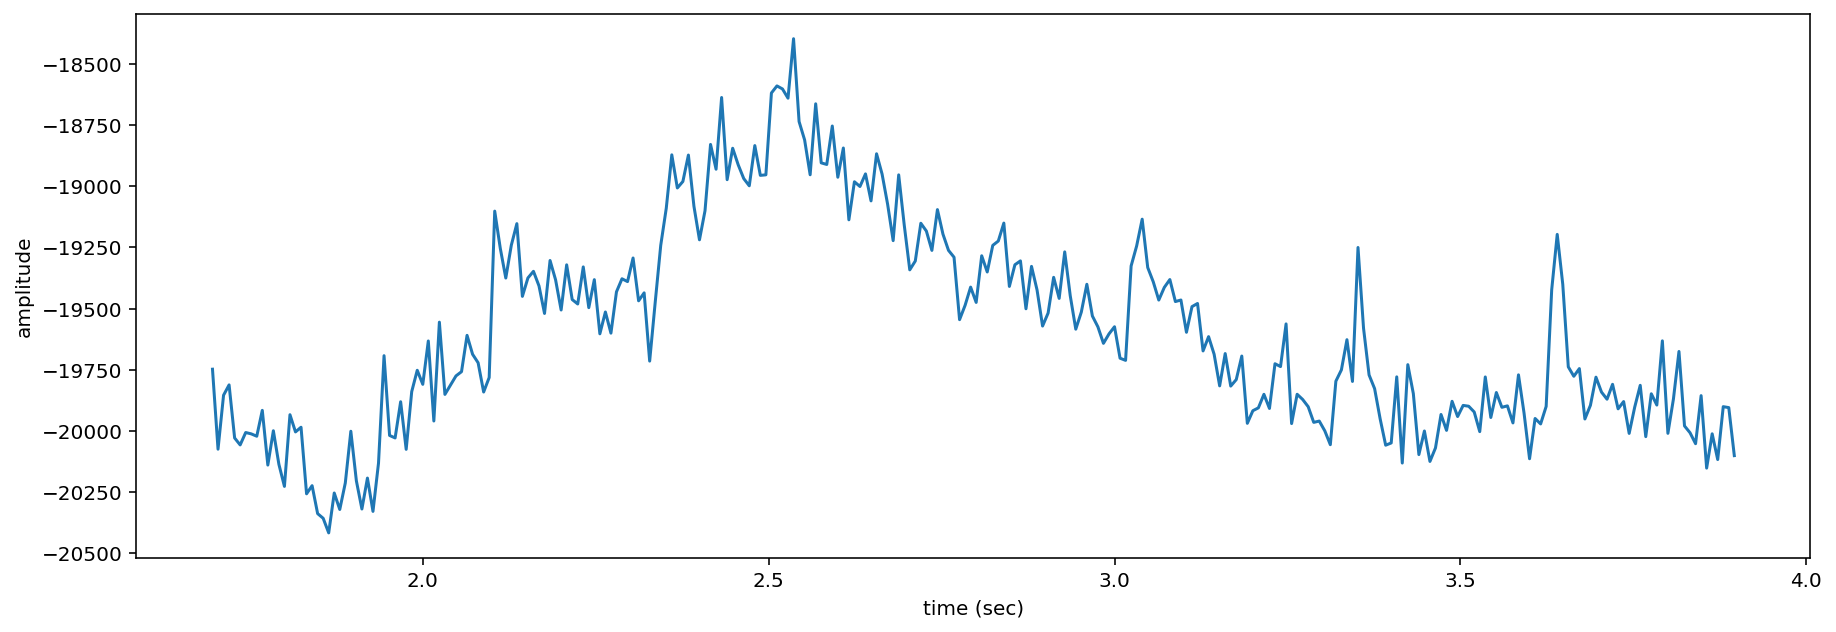

In [35]:
# calculate amplitude signal
high_freq_amplitude = spec_trimmed.amplitude()

# plot
from matplotlib import pyplot as plt
plt.plot(spec_trimmed.times,high_freq_amplitude)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

It is also possible to get the amplitude signal from a restricted range of frequencies, for instance, to look at the amplitude in the frequency range of a species of interest. For example, get the amplitude signal from the 8000 Hz to 8500 Hz range of the audio (displayed below):

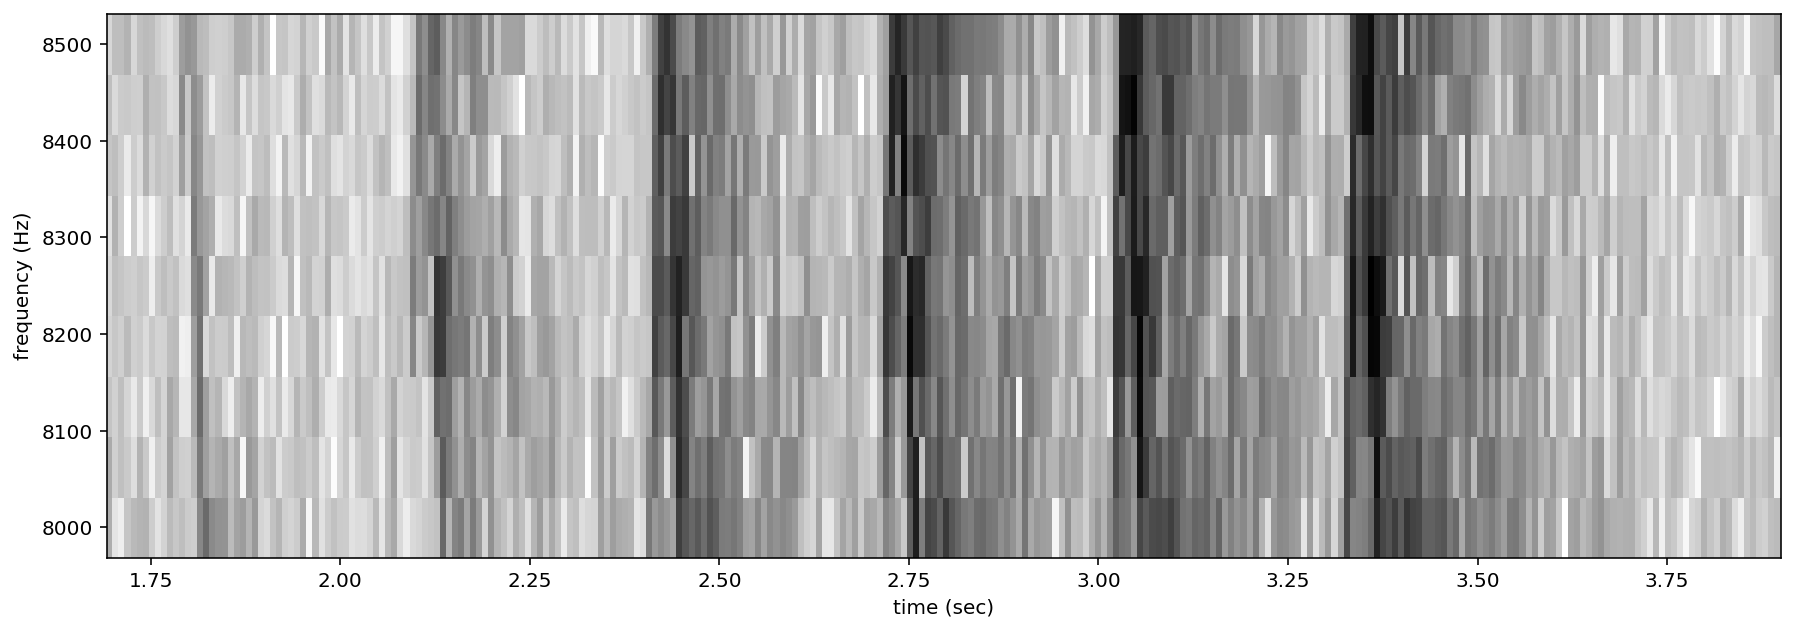

In [36]:
spec_bandpassed = spec_trimmed.bandpass(8000, 8500)
spec_bandpassed.plot()

Get and plot the amplitude signal of only 8-8.5 kHz.

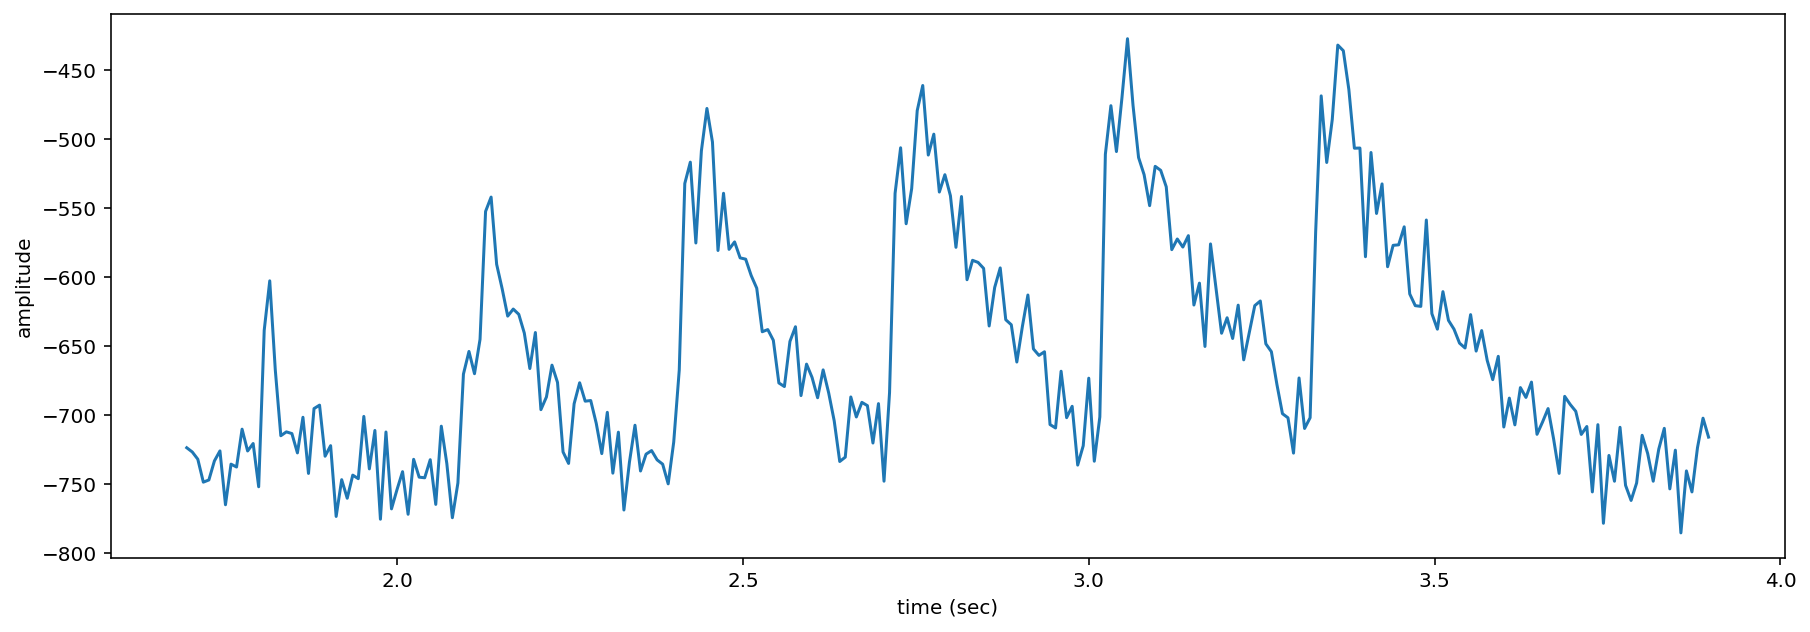

In [37]:
# Get amplitude signal
high_freq_amplitude = spec_trimmed.amplitude(freq_range=[8000,8500])

# Get amplitude signal
high_freq_amplitude = spec_trimmed.amplitude(freq_range=[8000,8500])

# Plot signal
plt.plot(spec_trimmed.times, high_freq_amplitude)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()

Amplitude signals like these can be used to identify periodic calls, like those by many species of frogs. A pulsing-call identification pipeline called [RIBBIT](RIBBIT_pulse_rate_demo.html) is implemented in OpenSoundscape.

Amplitude signals may not be the most reliable method of identification for species like birds. In this case, it is possible to create a machine learning algorithm to identify calls based on their appearance on spectrograms. 

The developers of OpenSoundscape have trained machine learning models for over 500 common North American bird species; for examples of how to download demonstration models, see the "Prediction with pretrained models" tutorial.